# **The Transformer Model**

This notebook will explore machine translation using a transformer model. As noted, the following code in the notebook borrows heavily from the [Tensorflow tutorial](https://www.tensorflow.org/text/tutorials/transformer). I have indicated which code is from the tutorial.

In [2]:
# Imports the Tranformer library
import Transformer as tran

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_text

2023-06-02 01:52:08.484350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-02 01:52:08.485541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-02 01:52:08.485549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Preparing and Exploring the Data

The data is in a CSV file, with a column for the Kiche and Spanish examples. The columns will be split and converted into tensors; the training examples are also converted to lower-case and a space is added between the words and punctuation marks. The `BUFFER_SIZE` and `BATCH_SIZE` variables and the `split_test_val` function are taken from the [seq2seq tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

In [3]:
filepath = 'Bilingual Corpus.csv'
source = 'Kiche'
target = 'Spanish'

all_ki, all_sp = tran.preclean(filepath, source, target)

In [4]:
BUFFER_SIZE = len(all_ki)
BATCH_SIZE = 64

training, validation = tran.split_test_val(all_ki, all_sp, BUFFER_SIZE, BATCH_SIZE)

In [4]:
for example_ki, example_sp in training:
    print('> Examples in Kiche:')
    for ki in example_ki[:5].numpy():
        print(ki.decode('utf-8'))
    print()
    print('> Examples in Spanish:')
    for sp in example_sp[:5].numpy():
        print(sp.decode('utf-8'))
    break

> Examples in Kiche:
b’elejeb’ sient ruk’ kawinaq lajuj  u junab’ ri noe aretaq xkamik .
um , apek xuquje’ rehob’ , chi konojel e juwinaq kieb’ tinimit taq , e kachil ri e u q’ab’ taq ki tinimit ri e k’o che ki k’ultaqja .
xintz’onon che ri ajawaxel , ri are’ xutzelej u wach ri xintz’onoj che , xinresaj k’u pa konojel ri nu xib’rikil .
ri jakob’ xub’ij che ri esau :  “loq’alaj wachalal , at aweta’m chi ri ak’alab’ maja’ e ko , xuquje’ e k’o chij xuquje’ wakax ri k’o alaj taq kal ; we sib’alaj kaya’ kosik chke , kraj ne kekam konojel ri chij xa pa jun q’ij .
ri e rija’lil ri manases k’o ri taanak , pa ki q’ab’ , ri meguid xuquje’ ri dor , e kachil taq ri alaj taq ki tinimit . chupam taq we k’olb’al ri’ xejeqi’ wi ri e rija’lil ri jose , u k’ojol ri israel .

> Examples in Spanish:
noé vivió en total 950 años , y entonces murió .
uma , afec y rejob – veintidós ciudades con sus aldeas .
busqué al señor , y él me oyó ; y me libró de todos mis temores .
 “mi señor puede ver que los niños so

## Tokenization

In this section, the tokenizer models are loaded and the training and validation datasets are batched. I do some exploring with the tokenizers.

The code in this section is from the tutorial.

In [5]:
saved_model = 'kiche_spanish_tokens'

tf.keras.utils.get_file(f'{saved_model}.zip',
                        f'C:\\Users\\wang\\Desktop\\Kiche-Spanish Translator\\{saved_model}.zip',
                        cache_dir='.', cache_subdir='', extract=True)

'./kiche_spanish_tokens.zip'

In [6]:
tokenizers = tf.saved_model.load(saved_model)

I explore the Kiche tokenizer.

In [7]:
# Print out the methods of the Kiche tokenizer
[item for item in dir(tokenizers.ki) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [8]:
# Untokenized text
print('> This is a batch of strings:')
for ki in example_ki[:5].numpy():
    print(ki.decode('utf-8'))

> This is a batch of strings:
b’elejeb’ sient ruk’ kawinaq lajuj  u junab’ ri noe aretaq xkamik .
um , apek xuquje’ rehob’ , chi konojel e juwinaq kieb’ tinimit taq , e kachil ri e u q’ab’ taq ki tinimit ri e k’o che ki k’ultaqja .
xintz’onon che ri ajawaxel , ri are’ xutzelej u wach ri xintz’onoj che , xinresaj k’u pa konojel ri nu xib’rikil .
ri jakob’ xub’ij che ri esau :  “loq’alaj wachalal , at aweta’m chi ri ak’alab’ maja’ e ko , xuquje’ e k’o chij xuquje’ wakax ri k’o alaj taq kal ; we sib’alaj kaya’ kosik chke , kraj ne kekam konojel ri chij xa pa jun q’ij .
ri e rija’lil ri manases k’o ri taanak , pa ki q’ab’ , ri meguid xuquje’ ri dor , e kachil taq ri alaj taq ki tinimit . chupam taq we k’olb’al ri’ xejeqi’ wi ri e rija’lil ri jose , u k’ojol ri israel .


In [9]:
# Tokenized text
tokenized_ki = tokenizers.ki.tokenize(example_ki[:5])

print('> This is a padded-batch of token IDs:')
for row in tokenized_ki.to_list():
    print(row)

> This is a padded-batch of token IDs:
[2, 27, 57, 1318, 57, 290, 87, 57, 418, 240, 46, 186, 57, 60, 1395, 105, 896, 11, 3]
[2, 728, 9, 4680, 66, 57, 3637, 57, 9, 64, 102, 30, 315, 185, 57, 92, 63, 9, 30, 816, 60, 30, 46, 42, 57, 77, 57, 63, 73, 92, 60, 30, 36, 57, 40, 61, 73, 36, 57, 1398, 1548, 1451, 11, 3]
[2, 1583, 57, 1603, 61, 60, 80, 9, 60, 70, 57, 360, 46, 107, 60, 1583, 57, 384, 61, 9, 3663, 36, 57, 46, 62, 102, 60, 94, 349, 57, 1071, 11, 3]
[2, 60, 336, 57, 90, 57, 67, 61, 60, 873, 23, 58, 133, 57, 97, 693, 9, 128, 871, 57, 38, 64, 60, 184, 57, 485, 57, 599, 57, 30, 275, 9, 66, 57, 30, 36, 57, 40, 230, 66, 57, 291, 60, 36, 57, 40, 97, 63, 1004, 24, 76, 110, 57, 97, 270, 57, 275, 1065, 95, 9, 894, 144, 737, 102, 60, 230, 140, 62, 72, 42, 57, 67, 11, 3]
[2, 60, 30, 257, 57, 234, 60, 685, 36, 57, 40, 60, 69, 2199, 284, 9, 62, 73, 42, 57, 77, 57, 9, 60, 4209, 66, 57, 60, 29, 1128, 9, 30, 816, 63, 60, 97, 63, 73, 92, 11, 112, 63, 76, 36, 57, 176, 57, 65, 60, 57, 1306, 57, 85, 60, 

In [10]:
# Detokenized text
detokenized_ki = tokenizers.ki.detokenize(tokenized_ki)

print('> This is human-readable text:')
for line in detokenized_ki.numpy():
    print(line.decode('utf-8'))

> This is human-readable text:
b ’ elejeb ’ sient ruk ’ kawinaq lajuj u junab ’ ri noe aretaq xkamik .
um , apek xuquje ’ rehob ’ , chi konojel e juwinaq kieb ’ tinimit taq , e kachil ri e u q ’ ab ’ taq ki tinimit ri e k ’ o che ki k ’ ultaqja .
xintz ’ onon che ri ajawaxel , ri are ’ xutzelej u wach ri xintz ’ onoj che , xinresaj k ’ u pa konojel ri nu xib ’ rikil .
ri jakob ’ xub ’ ij che ri esau : “ loq ’ alaj wachalal , at aweta ’ m chi ri ak ’ alab ’ maja ’ e ko , xuquje ’ e k ’ o chij xuquje ’ wakax ri k ’ o alaj taq kal ; we sib ’ alaj kaya ’ kosik chke , kraj ne kekam konojel ri chij xa pa jun q ’ ij .
ri e rija ’ lil ri manases k ’ o ri taanak , pa ki q ’ ab ’ , ri meguid xuquje ’ ri dor , e kachil taq ri alaj taq ki tinimit . chupam taq we k ’ olb ’ al ri ’ xejeqi ’ wi ri e rija ’ lil ri jose , u k ’ ojol ri israel .


In [11]:
# The tokens with their corresponding wordpieces
print('> This is the text split into tokens:')
tokens_ki = tokenizers.ki.lookup(tokenized_ki)
tokens_ki

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'b', b'\xe2\x80\x99', b'elejeb', b'\xe2\x80\x99', b'sient',
  b'ruk', b'\xe2\x80\x99', b'kawinaq', b'lajuj', b'u', b'junab',
  b'\xe2\x80\x99', b'ri', b'noe', b'aretaq', b'xkamik', b'.', b'[END]']   ,
 [b'[START]', b'um', b',', b'apek', b'xuquje', b'\xe2\x80\x99', b'rehob',
  b'\xe2\x80\x99', b',', b'chi', b'konojel', b'e', b'juwinaq', b'kieb',
  b'\xe2\x80\x99', b'tinimit', b'taq', b',', b'e', b'kachil', b'ri', b'e',
  b'u', b'q', b'\xe2\x80\x99', b'ab', b'\xe2\x80\x99', b'taq', b'ki',
  b'tinimit', b'ri', b'e', b'k', b'\xe2\x80\x99', b'o', b'che', b'ki', b'k',
  b'\xe2\x80\x99', b'ul', b'##taq', b'##ja', b'.', b'[END]']                ,
 [b'[START]', b'xintz', b'\xe2\x80\x99', b'onon', b'che', b'ri',
  b'ajawaxel', b',', b'ri', b'are', b'\xe2\x80\x99', b'xutzelej', b'u',
  b'wach', b'ri', b'xintz', b'\xe2\x80\x99', b'onoj', b'che', b',',
  b'xinresaj', b'k', b'\xe2\x80\x99', b'u', b'pa', b'konojel', b'ri', b'nu',
  b'xib', b'\xe2\x80\x99', b'rikil', b'

I explore the Spanish tokenizer.

In [12]:
# Print out the methods of the Spanish tokenizer
[item for item in dir(tokenizers.sp) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [13]:
# Untokenized text
print('> This is a batch of strings:')
for sp in example_sp[:5].numpy():
    print(sp.decode('utf-8'))

> This is a batch of strings:
noé vivió en total 950 años , y entonces murió .
uma , afec y rejob – veintidós ciudades con sus aldeas .
busqué al señor , y él me oyó ; y me libró de todos mis temores .
 “mi señor puede ver que los niños son débiles ” , respondió jacob .  “también las cabras , las ovejas y el ganado están amamantando a sus crías , y si los presiono demasiado , todos morirán .
y a la parte de los hijos de manasés , bet-seán con sus aldeas , taanac con sus aldeas , meguido con sus aldeas , y dor con sus aldeas . en estos lugares habitaron los hijos de josé , hijo de israel .


In [14]:
# Tokenized text
tokenized_sp = tokenizers.sp.tokenize(example_sp[:5])

print('> This is a padded-batch of token IDs:')
for row in tokenized_sp.to_list():
    print(row)

> This is a padded-batch of token IDs:
[2, 1283, 1264, 69, 1093, 21, 3420, 215, 8, 49, 106, 532, 10, 3]
[2, 45, 753, 8, 6239, 49, 42, 6076, 792, 58, 2759, 245, 76, 80, 839, 10, 3]
[2, 3309, 79, 73, 8, 49, 65, 93, 723, 23, 49, 93, 419, 64, 96, 141, 5989, 10, 3]
[2, 62, 81, 73, 421, 404, 66, 68, 738, 136, 5778, 63, 8, 202, 275, 10, 62, 120, 78, 1627, 8, 78, 427, 49, 65, 677, 217, 890, 4458, 1724, 25, 80, 4294, 8, 49, 102, 68, 40, 432, 3146, 241, 2602, 8, 96, 1741, 10, 3]
[2, 49, 25, 67, 267, 64, 68, 110, 64, 581, 8, 574, 9, 438, 76, 80, 839, 8, 44, 137, 4744, 947, 76, 80, 839, 8, 4986, 76, 80, 839, 8, 49, 28, 1316, 76, 80, 839, 10, 69, 213, 693, 1951, 68, 110, 64, 352, 8, 107, 64, 112, 10, 3]


In [15]:
# Detokenized text
detokenized_sp = tokenizers.sp.detokenize(tokenized_sp)

print('> This is human-readable text:')
for line in detokenized_sp.numpy():
    print(line.decode('utf-8'))

> This is human-readable text:
noe vivio en total 950 anos , y entonces murio .
uma , afec y rejob – veintidos ciudades con sus aldeas .
busque al senor , y el me oyo ; y me libro de todos mis temores .
“ mi senor puede ver que los ninos son debiles ” , respondio jacob . “ tambien las cabras , las ovejas y el ganado estan amamantando a sus crias , y si los presiono demasiado , todos moriran .
y a la parte de los hijos de manases , bet - sean con sus aldeas , taanac con sus aldeas , meguido con sus aldeas , y dor con sus aldeas . en estos lugares habitaron los hijos de jose , hijo de israel .


In [16]:
# The tokens with their corresponding wordpieces
print('> This is the text split into tokens:')
tokens_sp = tokenizers.sp.lookup(tokenized_sp)
tokens_sp

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'noe', b'vivio', b'en', b'total', b'9', b'##50', b'anos',
  b',', b'y', b'entonces', b'murio', b'.', b'[END]']                    ,
 [b'[START]', b'u', b'##ma', b',', b'afec', b'y', b'r', b'##ejo', b'##b',
  b'\xe2\x80\x93', b'veintidos', b'ciudades', b'con', b'sus', b'aldeas',
  b'.', b'[END]']                                                        ,
 [b'[START]', b'busque', b'al', b'senor', b',', b'y', b'el', b'me', b'oyo',
  b';', b'y', b'me', b'libro', b'de', b'todos', b'mis', b'temores', b'.',
  b'[END]']                                                                ,
 [b'[START]', b'\xe2\x80\x9c', b'mi', b'senor', b'puede', b'ver', b'que',
  b'los', b'ninos', b'son', b'debiles', b'\xe2\x80\x9d', b',', b'respondio',
  b'jacob', b'.', b'\xe2\x80\x9c', b'tambien', b'las', b'cabras', b',',
  b'las', b'ovejas', b'y', b'el', b'ganado', b'estan', b'ama', b'##man',
  b'##tando', b'a', b'sus', b'crias', b',', b'y', b'si', b'los', b'p',
  b'##res', b'##ion'

Here the tokens per example by frequency is visualized.

In [17]:
# The lengths of tokens per example are appended to a list
lengths = []

for example_ki, example_sp in training:
    ki_tokens = tokenizers.ki.tokenize(example_ki)
    lengths.append(ki_tokens.row_lengths())

    sp_tokens = tokenizers.sp.tokenize(example_sp)
    lengths.append(sp_tokens.row_lengths())
    print('.', end='', flush=True)

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Text(0.5, 1.0, 'Maximum tokens per example: 211')

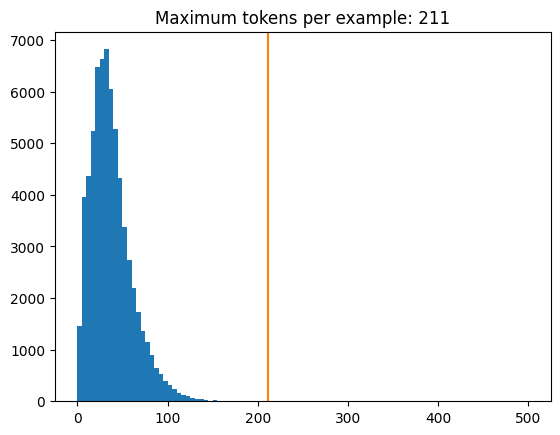

In [18]:
# The lengths of tokens are plotted by frequency
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}')

The training and validation sets are organized into batches. I also explore some of the batched data. The `sp_labels` variable represents the output of the model. In the training, the inputs are both the source and target languages; the source language sentences are fed into the encoder and the target language sentences into the decoder. This is a technique called "teacher forcing". These inputs are represented by the `ki` and `sp` variables, respectively.

The `sp` sentences have the start-tokens removed; the `sp_labels` sentences have the end-tokens removed.

In [7]:
MAX_TOKENS = 128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# Create training and validation set batches
train_batches = tran.make_batches(training,
                                  tokenizers.ki,
                                  tokenizers.sp,
                                  BUFFER_SIZE)

val_batches = tran.make_batches(validation,
                                tokenizers.ki,
                                tokenizers.sp,
                                BUFFER_SIZE)

In [20]:
# Check the shape of the inputs and outputs
for (ki, sp), sp_labels in train_batches.take(1):
    break

print(ki.shape)
print(sp.shape)
print(sp_labels.shape)

(64, 100)
(64, 128)
(64, 128)


In [21]:
# 2 represents the start-token
print(sp[0][:10])
print(sp_labels[0][:10])

tf.Tensor([   2   49   76  105  138    8   67 1550   74  672], shape=(10,), dtype=int64)
tf.Tensor([  49   76  105  138    8   67 1550   74  672  169], shape=(10,), dtype=int64)


## Exploring the Components

In this section, I will explore and test some of the components of the transformer. The components were defined as classes in the associated Transformer library; these included classes for:

- a positional embedding layer
- cross-attention, global self-attention, & causal attention layers
- a feed forward layer
- an encoder layer
- an encoder
- a decoder layer
- a decoder

Once again, the code in this section is taken from the tutorial. The depth and length parameters were taken from one of [Eryk Wdowiak's parameters for his training of a Sicilian-English translator](https://www.doviak.net/pages/ml-sicilian/ml-scn_p05.shtml); he also worked on a low-resource language.

(1536, 384)


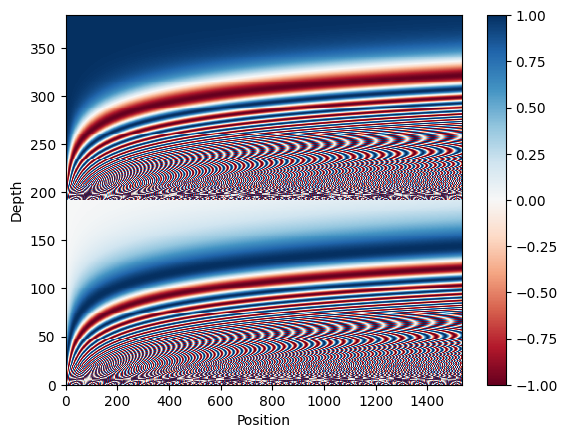

In [22]:
# Create a set of position vectors
pos_encoding = tran.positional_encoding(length=1536, depth=384)

# Check the shape
print(pos_encoding.shape)

# Plot the dimensions
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

The following plots show the similarity of the vector at position 1000 from the rest. The vectors were compared by dot product.

(0.0, 1.0)

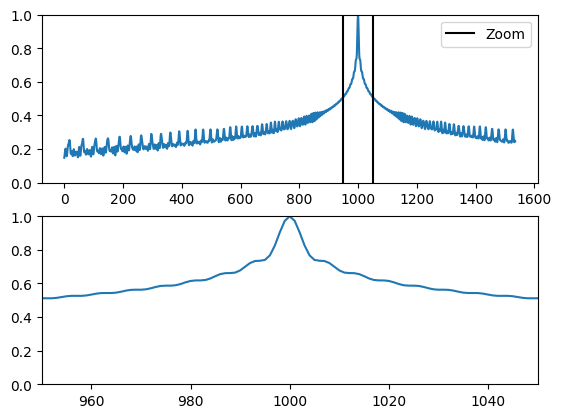

In [23]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)

p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)

plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()

plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [24]:
# Testing the positional embedding layer
embed_ki = tran.PositionalEmbedding(vocab_size=tokenizers.ki.get_vocab_size(), d_model=384, length=1536)
embed_sp = tran.PositionalEmbedding(vocab_size=tokenizers.sp.get_vocab_size(), d_model=384, length=1536)

ki_emb = embed_ki(ki)
sp_emb = embed_sp(sp)

In [25]:
sp_emb._keras_mask

<tf.Tensor: shape=(64, 128), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [26]:
# Testing the cross-attention layer
sample = tran.CrossAttention(num_heads=2, key_dim=384)

print(ki_emb.shape)
print(sp_emb.shape)
print(sample(sp_emb, ki_emb).shape)

(64, 100, 384)
(64, 128, 384)
(64, 128, 384)


In [27]:
# Testing the global self-attention layer
sample = tran.GlobalSelfAttention(num_heads=2, key_dim=384)

print(ki_emb.shape)
print(sample(ki_emb).shape)

(64, 100, 384)
(64, 100, 384)


In [28]:
# Testing the causal self-attention layer
sample = tran.CausalSelfAttention(num_heads=2, key_dim=384)

print(sp_emb.shape)
print(sample(sp_emb).shape)

(64, 128, 384)
(64, 128, 384)


In [29]:
# Because the causal attention is autoregressive, the elements earlier in the sequence don't depend on the later ones
# So, trimming before or after applying this attention layer should not affect the outputs too much

out1 = sample(embed_sp(sp[:, :3]))
out2 = sample(embed_sp(sp))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

0.20535605

In [30]:
# Testing the feed forward layer
sample = tran.FeedForward(384, 1536, 0.3)

print(sp_emb.shape)
print(sample(sp_emb).shape)

(64, 128, 384)
(64, 128, 384)


In [31]:
# Testing an encoder layer
sample = tran.EncoderLayer(d_model=384, num_heads=6,
                           dff=1536, gsa_dropout=0.33, ff_dropout=0.5)

print(ki_emb.shape)
print(sample(ki_emb).shape)

(64, 100, 384)
(64, 100, 384)


In [32]:
# Testing the encoder
sample = tran.Encoder(num_layers=4, d_model=384,
                      length=1536, num_heads=6,
                      dff=1536, vocab_size=8500,
                      gsa_dropout=0.33, ff_dropout=0.5,
                      layer_dropout=0.5)

sample_output = sample(ki, training=False)

print(ki.shape)
print(sample_output.shape)

(64, 100)
(64, 100, 384)


In [33]:
# Testing a decoder layer
sample = tran.DecoderLayer(d_model=384, num_heads=6,
                           dff=1536, csa_dropout=0.33,
                           ca_dropout=0.33, ff_dropout=0.5)

sample_output = sample(x=sp_emb, context=ki_emb)

print(sp_emb.shape)
print(ki_emb.shape)
print(sample_output.shape)

(64, 128, 384)
(64, 100, 384)
(64, 128, 384)


In [34]:
# Testing a decoder
sample = tran.Decoder(num_layers=4, d_model=384,
                      length=1536, num_heads=6,
                      dff=1536, vocab_size=8000,
                      layer_dropout=0.5, csa_dropout=0.33,
                      ca_dropout=0.33, ff_dropout=0.5)

output = sample(x=sp, context=ki_emb)

print(sp.shape)
print(ki_emb.shape)
print(output.shape)

(64, 128)
(64, 100, 384)
(64, 128, 384)


In [35]:
sample.last_attn_scores.shape

TensorShape([64, 6, 128, 100])

## First Training

This is the first training session of the model. The entire transformer was defined as another class, using the previously defined layer classes.

Once again, the length and depth parameters, and amount of encoder and decoder layers, are taken from [Eryk Wdowiak's parameters](https://www.doviak.net/pages/ml-sicilian/ml-scn_p05.shtml). The dropout rates are high to prevent overfitting; they were arbitrary chosen to be 0.5 and 0.33.

The model was trained for 30 epochs to fit in the 4 hour limit in AWS Sagemaker Studio Lab. The weights are then saved for later training. Each subsequent training session required the data to be preprocessed again, the tokenizers reloaded, and the transformer reinstantiated and recompiled; the preprocessing step randomizes data, so a different training session may encounter new sentences.

Once again, the code is taken from the tutorial.

In [36]:
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

output = transformer((ki, sp))

print(sp.shape)
print(ki.shape)
print(output.shape)

(64, 128)
(64, 100)
(64, 128, 6679)


In [37]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)

(64, 6, 128, 100)


In [38]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  20832384  
                                                                 
 decoder_1 (Decoder)         multiple                  35670144  
                                                                 
 dense_38 (Dense)            multiple                  2571415   
                                                                 
Total params: 59,073,943
Trainable params: 59,073,943
Non-trainable params: 0
_________________________________________________________________


In [39]:
learning_rate = tran.CustomSchedule(384, 4000)

# An Adam optimizer was used
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

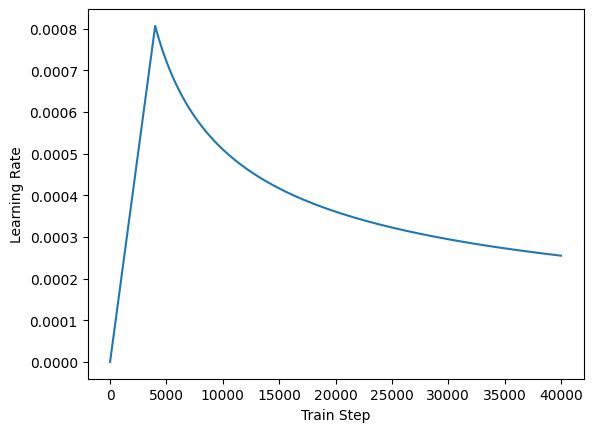

In [40]:
# This is to visualize the learning rate changes from the scheduler
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [41]:
transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [42]:
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30
522/522 [==============================] - 424s 758ms/step - loss: 6.7464 - masked_accuracy: 0.0921 - val_loss: 5.5925 - val_masked_accuracy: 0.1648
Epoch 2/30
522/522 [==============================] - 412s 788ms/step - loss: 5.2275 - masked_accuracy: 0.1823 - val_loss: 4.8210 - val_masked_accuracy: 0.2065
Epoch 3/30
522/522 [==============================] - 385s 736ms/step - loss: 4.6735 - masked_accuracy: 0.2150 - val_loss: 4.4079 - val_masked_accuracy: 0.2345
Epoch 4/30
522/522 [==============================] - 405s 776ms/step - loss: 4.3257 - masked_accuracy: 0.2384 - val_loss: 4.1236 - val_masked_accuracy: 0.2562
Epoch 5/30
522/522 [==============================] - 392s 751ms/step - loss: 4.0616 - masked_accuracy: 0.2580 - val_loss: 3.9025 - val_masked_accuracy: 0.2785
Epoch 6/30
522/522 [==============================] - 400s 765ms/step - loss: 3.8583 - masked_accuracy: 0.2742 - val_loss: 3.7320 - val_masked_accuracy: 0.2931
Epoch 7/30
522/522 [====================

In [43]:
transformer.save_weights('transformer_weights_30')

## Second Training

The model is retrained for another 30 epochs.

Once again, the code is taken from the tutorial.

In [7]:
# Instantiates the transformer again
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

# Loads previously saved weights
transformer.load_weights('transformer_weights_30')

learning_rate = tran.CustomSchedule(384, 4000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [8]:
# Trains the model again
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30
522/522 [==============================] - 432s 761ms/step - loss: 2.2554 - masked_accuracy: 0.4729 - val_loss: 1.8950 - val_masked_accuracy: 0.5443
Epoch 2/30
522/522 [==============================] - 398s 762ms/step - loss: 2.2041 - masked_accuracy: 0.4791 - val_loss: 2.0156 - val_masked_accuracy: 0.5206
Epoch 3/30
522/522 [==============================] - 390s 748ms/step - loss: 2.1612 - masked_accuracy: 0.4850 - val_loss: 2.0812 - val_masked_accuracy: 0.5090
Epoch 4/30
522/522 [==============================] - 402s 770ms/step - loss: 2.1216 - masked_accuracy: 0.4918 - val_loss: 2.1352 - val_masked_accuracy: 0.5031
Epoch 5/30
522/522 [==============================] - 403s 773ms/step - loss: 2.0844 - masked_accuracy: 0.4964 - val_loss: 2.1916 - val_masked_accuracy: 0.4958
Epoch 6/30
522/522 [==============================] - 404s 774ms/step - loss: 2.0593 - masked_accuracy: 0.5005 - val_loss: 2.2480 - val_masked_accuracy: 0.4859
Epoch 7/30
522/522 [====================

In [9]:
# New weights are saved
transformer.save_weights('transformer_weights_60')

## Third Training

The model is retrained for another 30 epochs.

Once again, the code is taken from the tutorial.

In [7]:
# Instantiates the transformer again
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

# Loads previously saved weights
transformer.load_weights('transformer_weights_60')

learning_rate = tran.CustomSchedule(384, 4000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [ ]:
# Trains the model again
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

# This output was accidentally deleted after training!

In [9]:
# New weights are saved
transformer.save_weights('transformer_weights_90')

## Fourth Training

The model is retrained for another 30 epochs.

Once again, the code is taken from the tutorial.

In [7]:
# Instantiates the transformer again
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

# Loads previously saved weights
transformer.load_weights('transformer_weights_90')

learning_rate = tran.CustomSchedule(384, 4000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [ ]:
# Trains the model again
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30
522/522 [==============================] - 416s 733ms/step - loss: 1.3387 - masked_accuracy: 0.6481 - val_loss: 0.8230 - val_masked_accuracy: 0.7847
Epoch 2/30
522/522 [==============================] - 396s 759ms/step - loss: 1.2957 - masked_accuracy: 0.6537 - val_loss: 0.8783 - val_masked_accuracy: 0.7679
Epoch 3/30
522/522 [==============================] - 389s 744ms/step - loss: 1.2687 - masked_accuracy: 0.6574 - val_loss: 0.9507 - val_masked_accuracy: 0.7454
Epoch 4/30
522/522 [==============================] - 396s 759ms/step - loss: 1.2478 - masked_accuracy: 0.6613 - val_loss: 0.9913 - val_masked_accuracy: 0.7358
Epoch 5/30
522/522 [==============================] - 387s 742ms/step - loss: 1.2238 - masked_accuracy: 0.6656 - val_loss: 1.0620 - val_masked_accuracy: 0.7172
Epoch 6/30
522/522 [==============================] - 387s 742ms/step - loss: 1.2061 - masked_accuracy: 0.6687 - val_loss: 1.1099 - val_masked_accuracy: 0.7045
Epoch 7/30
522/522 [====================

In [10]:
# New weights are saved
transformer.save_weights('transformer_weights_120')

## Fifth Training

The model is retrained for another 30 epochs.

Once again, the code is taken from the tutorial.

In [7]:
# Instantiates the transformer again
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

# Loads previously saved weights
transformer.load_weights('transformer_weights_120')

learning_rate = tran.CustomSchedule(384, 4000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [ ]:
# Trains the model again
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30
522/522 [==============================] - 467s 822ms/step - loss: 1.1171 - masked_accuracy: 0.6976 - val_loss: 0.5852 - val_masked_accuracy: 0.8461
Epoch 2/30
522/522 [==============================] - 424s 813ms/step - loss: 1.0808 - masked_accuracy: 0.7019 - val_loss: 0.6425 - val_masked_accuracy: 0.8270
Epoch 3/30
522/522 [==============================] - 422s 809ms/step - loss: 1.0487 - masked_accuracy: 0.7074 - val_loss: 0.6951 - val_masked_accuracy: 0.8124
Epoch 4/30
522/522 [==============================] - 429s 822ms/step - loss: 1.0277 - masked_accuracy: 0.7108 - val_loss: 0.7453 - val_masked_accuracy: 0.7986
Epoch 5/30
522/522 [==============================] - 432s 828ms/step - loss: 1.0079 - masked_accuracy: 0.7146 - val_loss: 0.7918 - val_masked_accuracy: 0.7832
Epoch 6/30
522/522 [==============================] - 432s 827ms/step - loss: 0.9924 - masked_accuracy: 0.7183 - val_loss: 0.8219 - val_masked_accuracy: 0.7749
Epoch 7/30
522/522 [====================

In [11]:
# New weights are saved
transformer.save_weights('transformer_weights_150')

## Sixth Training

The model is retrained for another 30 epochs.

Once again, the code is taken from the tutorial.

In [7]:
# Instantiates the transformer again
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

# Loads previously saved weights
transformer.load_weights('transformer_weights_150')

learning_rate = tran.CustomSchedule(384, 4000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [ ]:
# Trains the model again
transformer.fit(train_batches,
                epochs=30,
                validation_data=val_batches)

Epoch 1/30
522/522 [==============================] - 450s 799ms/step - loss: 0.9431 - masked_accuracy: 0.7383 - val_loss: 0.4358 - val_masked_accuracy: 0.8860
Epoch 2/30
522/522 [==============================] - 399s 765ms/step - loss: 0.9061 - masked_accuracy: 0.7445 - val_loss: 0.4894 - val_masked_accuracy: 0.8686
Epoch 3/30
522/522 [==============================] - 425s 814ms/step - loss: 0.8817 - masked_accuracy: 0.7479 - val_loss: 0.5304 - val_masked_accuracy: 0.8547
Epoch 4/30
522/522 [==============================] - 422s 808ms/step - loss: 0.8625 - masked_accuracy: 0.7514 - val_loss: 0.5622 - val_masked_accuracy: 0.8445
Epoch 5/30
522/522 [==============================] - 415s 795ms/step - loss: 0.8479 - masked_accuracy: 0.7545 - val_loss: 0.6054 - val_masked_accuracy: 0.8306
Epoch 6/30
522/522 [==============================] - 406s 777ms/step - loss: 0.8343 - masked_accuracy: 0.7568 - val_loss: 0.6381 - val_masked_accuracy: 0.8234
Epoch 7/30
522/522 [====================

In [10]:
# New weights are saved
transformer.save_weights('transformer_weights_180')

## Seventh Training

The model is retrained for another 20 epochs; 20 was arbitrarily chosen to create an even hundred. Additionally, the accuracy score was improving too slowly.

Once again, the code is taken from the tutorial.

In [7]:
# Instantiates the transformer again
transformer = tran.Transformer(
                               num_layers=4,
                               d_model=384,
                               length=1536,
                               num_heads=6,
                               dff=1536,
                               input_vocab_size=tokenizers.ki.get_vocab_size().numpy(),
                               target_vocab_size=tokenizers.sp.get_vocab_size().numpy(),
                               gsa_dropout=0.33,
                               enc_ff_dropout=0.5,
                               enc_layer_dropout=0.5,
                               dec_layer_dropout=0.5,
                               csa_dropout=0.33,
                               ca_dropout=0.33,
                               dec_ff_dropout=0.5)

# Loads previously saved weights
transformer.load_weights('transformer_weights_180')

learning_rate = tran.CustomSchedule(384, 4000)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

transformer.compile(loss=tran.masked_loss, optimizer=optimizer, metrics=[tran.masked_accuracy])

In [ ]:
# Trains the model again
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
522/522 [==============================] - 445s 788ms/step - loss: 0.8168 - masked_accuracy: 0.7706 - val_loss: 0.3328 - val_masked_accuracy: 0.9131
Epoch 2/20
522/522 [==============================] - 412s 789ms/step - loss: 0.7814 - masked_accuracy: 0.7756 - val_loss: 0.3722 - val_masked_accuracy: 0.8993
Epoch 3/20
522/522 [==============================] - 410s 785ms/step - loss: 0.7400 - masked_accuracy: 0.7835 - val_loss: 0.4412 - val_masked_accuracy: 0.8802
Epoch 5/20
522/522 [==============================] - 412s 789ms/step - loss: 0.7234 - masked_accuracy: 0.7863 - val_loss: 0.4846 - val_masked_accuracy: 0.8654
Epoch 6/20
522/522 [==============================] - 407s 780ms/step - loss: 0.7154 - masked_accuracy: 0.7884 - val_loss: 0.4904 - val_masked_accuracy: 0.8617
Epoch 7/20
522/522 [==============================] - 409s 784ms/step - loss: 0.7077 - masked_accuracy: 0.7903 - val_loss: 0.5250 - val_masked_accuracy: 0.8536
Epoch 8/20
522/522 [====================

In [10]:
# New weights are saved
transformer.save_weights('transformer_weights_200')

## The Translation

Now that the model has been trained, we can instantiate the Translator class and translate a few sentences. This class does as its name implies, taking on a trained transformer as one of its inputs.

Again, much of the code here is taken from the tutorial.

In [11]:
translator = tran.Translator(tokenizers.ki, tokenizers.sp, transformer)

The following cells have some example sentences to translate. The ground truth is the expected output.

In [12]:
sentence = "na kawaj taj kinweta’m le qach’ab’al."
ground_truth = "no quiero aprender nuestra lengua."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
tran.print_translation(sentence, translated_text, ground_truth)

Input:         : na kawaj taj kinweta’m le qach’ab’al.
Prediction     : no comprendo que escandalo .
Ground truth   : no quiero aprender nuestra lengua.


In [13]:
sentence = "kawaj katinpaq’o."
ground_truth = "quiero golpearte."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
tran.print_translation(sentence, translated_text, ground_truth)

Input:         : kawaj katinpaq’o.
Prediction     : lo quieres .
Ground truth   : quiero golpearte.


In [14]:
sentence = "le achi xa tak’al puwi’ le laj juyub’ aretaq xojril loq."
ground_truth = "el hombre estaba parado en la cima de la pequeña colina cuando nos vio aquí."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
tran.print_translation(sentence, translated_text, ground_truth)

Input:         : le achi xa tak’al puwi’ le laj juyub’ aretaq xojril loq.
Prediction     : el hombre que fue al monte , vista en la montana .
Ground truth   : el hombre estaba parado en la cima de la pequeña colina cuando nos vio aquí.


In [15]:
sentence = "ri alaj ala ri tajin kretz’ab’ej ulew xyaj rumal ri nan Ixkem."
ground_truth = "el niñito que está jugando tierra fue regañado por la doña Ixkem."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
tran.print_translation(sentence, translated_text, ground_truth)

Input:         : ri alaj ala ri tajin kretz’ab’ej ulew xyaj rumal ri nan Ixkem.
Prediction     : y el hijo fue inutil en la tierra .
Ground truth   : el niñito que está jugando tierra fue regañado por la doña Ixkem.


In [16]:
sentence = "we ta xatz’iloj awib’, xatuyaj ta ri nunan."
ground_truth = "si te hubieras ensuciado, mi mamá te hubiera rengañado."

translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
tran.print_translation(sentence, translated_text, ground_truth)

Input:         : we ta xatz’iloj awib’, xatuyaj ta ri nunan.
Prediction     : si te acuestes tu gracias , no te a ti solo .
Ground truth   : si te hubieras ensuciado, mi mamá te hubiera rengañado.


The cells below plot a heatmap of the first attention head.

In [17]:
# First attention head
head = 0

attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([17, 18])

In [18]:
# Uses the last sentence tested and tokenizes it
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.ki.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.ki.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(18,), dtype=string, numpy=
array([b'[START]', b'we', b'ta', b'xatz', b'\xe2\x80\x99', b'iloj',
       b'awib', b'\xe2\x80\x99', b',', b'xa', b'##t', b'##uya', b'##j',
       b'ta', b'ri', b'nunan', b'.', b'[END]'], dtype=object)>

In [19]:
# The model's predictions
translated_tokens

<tf.Tensor: shape=(18,), dtype=string, numpy=
array([b'[START]', b'si', b'te', b'a', b'##c', b'##u', b'##es', b'##tes',
       b'tu', b'gracias', b',', b'no', b'te', b'a', b'ti', b'solo', b'.',
       b'[END]'], dtype=object)>

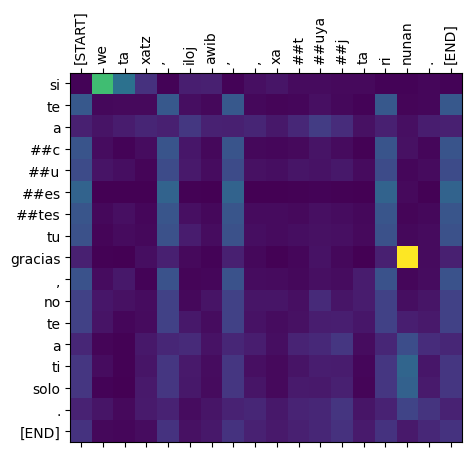

In [20]:
# Plots the attention
tran.plot_attention_head(in_tokens, translated_tokens, attention)

Here are the attention heatmaps of all the attention heads.

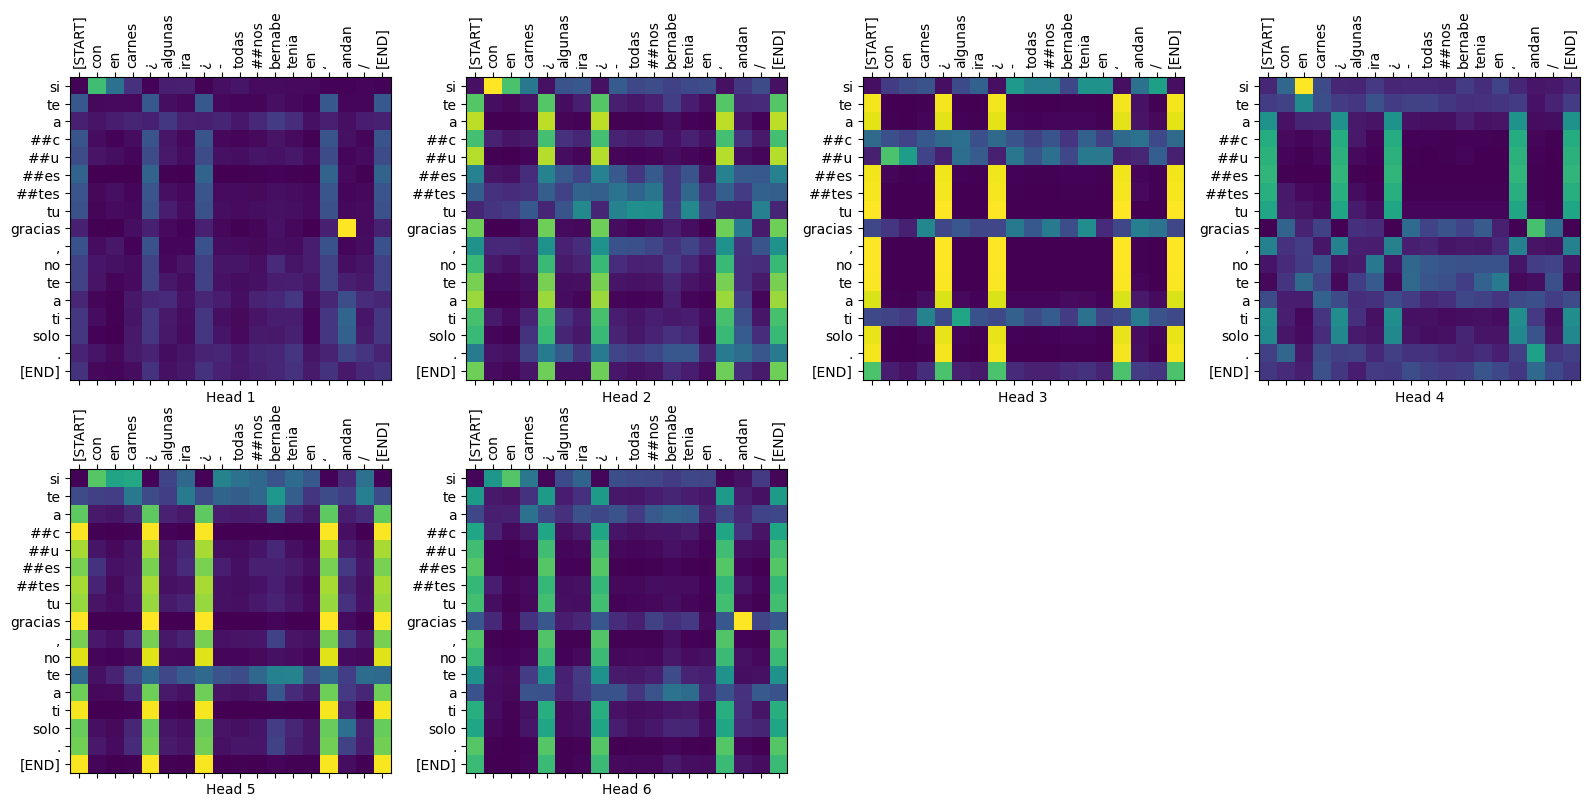

In [21]:
tran.plot_attention_weights(sentence,
                            tokenizers.ki,
                            tokenizers.sp,
                            translated_tokens,
                            attention_weights[0])

## Saving the Model

Using a previously defined class, ExportTranslator, the model is saved for later use.

Again, the code here is taken from the tutorial.

In [22]:
translator = tran.ExportTranslator(translator)

In [23]:
tf.saved_model.save(translator, export_dir='kiche_translator_transformer')

INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape([None, 384]), tf.float32, tf.int64, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f292a5c6a00>, 139815415043632), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 6, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f292a589b20>, 139814842911120), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f292a5dac10>, 139814842911280), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384, 6, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f292a5a8fa0>, 139814841934032), {}).
INFO:tensorflow:Unsupported signature for s

INFO:tensorflow:Assets written to: kiche_translator_transformer/assets


INFO:tensorflow:Assets written to: kiche_translator_transformer/assets


## Reloading and Testing the Model

The saved model is reloaded to verify that it was saved. The ExportTranslator class also contains a method that translates sentences, so that was tested too.

In [8]:
# The test data is prepared from the remaining data that was not used for training or validation
test_ki = all_ki[int(BUFFER_SIZE * 0.99):]
test_sp = all_sp[int(BUFFER_SIZE * 0.99):]

In [ ]:
# This was commented out because it normally takes too long to run

# for ki, sp in zip(test_ki, test_sp):
#     print("Kiche: " + ki)
#     print("Translated: " + str(translator(ki).numpy()))
#     print("Ground truth: " + sp)
#     print()

In [9]:
# The saved model is reloaded
reloaded = tf.saved_model.load('kiche_translator_transformer')

Here, the saved model `reloaded` is used to translate the sentence `ki`.

You may notice that the translations are significantly more accurate than the example sentences above, despite an accuracy score of roughly 0.8. This may be because the data was randomized every time before training; the `preclean` function randomizes the sentence pairs. This would have resulted in the model "remembering" the training sentence that now became a test sentence.

In [10]:
for ki, sp in zip(test_ki[:100], test_sp[:100]):
    print("Kiche: " + ki)
    print("Translated: " + str(reloaded(ki).numpy().decode("utf-8")))
    print("Ground truth: " + sp)
    print()

Kiche: kinux k’u na jun tataxel che , are k’u ri are’ kux na jun k’ojalaxel chwe . aretaq chub’an jun makunik , kink’ajisaj na u wach kinrapuj k’u na jacha’ kub’an ronojel tataxel che ri u k’ojol ,
Translated: yo le sere a el padre , y el me sera a mi hijo . y si el cometiere iniquidad , yo le castigare con vara de hombres .
Ground truth: yo le seré a él padre , y él me será a mí hijo . y si él cometiere iniquidad , yo le castigaré con vara de hombres , y con azotes de hijos de hombres ;

Kiche: we ángel ri’ xuraqaqej uchi’ xub’ij : chixi’j iwib’ cho ri dios , chiya uq’ij , rumal ri xopan ri q’otaj rech ri uq’atb’al tzij . chiq’ijila’j ri xb’anow ri kaj , ulew , ri plo xuquje’ jawje’ ri kak’iy wi ri ja’ .
Translated: diciendo : temed a dios , y dadle gloria ; y adorad al que ha venido al aquel tiempo ; y adorad al mar y a la tierra y a sus obras ; y virtud , y dios ha aquel que es venida del mar y a los cielos .
Ground truth: diciendo en alta voz : temed a dios , y dadle gloria ; porqu